# **CPE 313 - Advanced Machine Learning and Deep Learning**

# Prelim Skill Exam

**Name:** Canja, Tricha Maie

**Section:** CPE32S8

**Date Submitted:** March 14, 2024

**Instructor:** Engr. Roman Richard

## Resources:

https://www.kaggle.com/datasets/nih-chest-xrays/data

## Procedures:

#### Packages

In [126]:
import pandas as pd
import numpy as np

import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from itertools import chain
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report, auc

from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.mobilenet import MobileNet
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models, layers


import warnings
warnings.filterwarnings("ignore")

#### Preprocessing

In [127]:
## Entire list of X-Ray

xray_df = pd.read_csv('C:/Users/trich/OneDrive/Documents/Data/Data_Entry_2017.csv')

In [128]:
## Find .png files in directory

image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('C:/Users/trich/OneDrive/Documents/', 'Data', 'images*', '*', '*.png'))}  

print('Scans found:', len(image_paths), ', Total Headers', xray_df.shape[0])

Scans found: 112120 , Total Headers 112120


In [129]:
xray_df['path'] = xray_df['Image Index'].map(image_paths.get)

In [130]:
## Check for null values

xray_df.isna().sum()

Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
path                                0
dtype: int64

In [131]:
## Drop the 'Unnamed: 11'
## because empty values

xray_df.drop('Unnamed: 11', axis=1, inplace=True)

In [132]:
## Check shape of xray_df

xray_df.shape

(112120, 12)

In [133]:
## Find all data with label of 'No Finding'
## Removes the 'No Findings'

xray_df['Finding Labels'] = xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [134]:
## Extracting all unique labels
## labels that seperated by '|'

all_labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [135]:
## Check 3 samples

xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
74085,00018217_011.png,Atelectasis,11,18217,55,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,0
56039,00013993_095.png,,95,13993,43,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
81063,00019913_000.png,,0,19913,54,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0


In [136]:
## the values in 'Finding Labels' feature

all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [137]:
## This is for checking the disease in the dataset that are fewer than 1000
## Which means that we will only get with the common diseases

MIN_CASES = 1000

all_labels = [c_label for c_label in all_labels if xray_df[c_label].sum() > MIN_CASES]

print('Clean Labels ({})'.format(len(all_labels)))

for c_label in all_labels:
    print(c_label, '-', int(xray_df[c_label].sum()))

Clean Labels (13)
Atelectasis - 11559
Cardiomegaly - 2776
Consolidation - 4667
Edema - 2303
Effusion - 13317
Emphysema - 2516
Fibrosis - 1686
Infiltration - 19894
Mass - 5782
Nodule - 6331
Pleural_Thickening - 3385
Pneumonia - 1431
Pneumothorax - 5302


In [138]:
## adjust the weight of the samples
## the more labels findings have higher weights

sample_weights = xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()

xray_df = xray_df.sample(xray_df.shape[0], weights=sample_weights)
xray_df = xray_df.sample(40000, weights=sample_weights)

In [139]:
xray_df['disease_vec'] = xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [141]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = xray_df['Finding Labels'].map(lambda x: x[:4]))

In [142]:
## check the train & validation

print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


In [143]:
## create a another feature 'disease_vec'
## one-hot encoded

valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [144]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec,newLabel
37814,00009945_004.png,,4,9945,54,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[]
88301,00021841_003.png,Atelectasis|Effusion,3,21841,44,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[Atelectasis, Effusion]"
31231,00008141_000.png,,0,8141,19,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[]
94617,00024356_000.png,,0,24356,28,M,PA,2674,2957,0.143,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[]
86096,00021222_022.png,,22,21222,57,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69232,00017088_001.png,,1,17088,41,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[]
83013,00020405_031.png,Infiltration,31,20405,49,M,AP,3056,2544,0.139,...,0,0,1,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",[Infiltration]
15227,00003995_001.png,,1,3995,40,F,AP,2500,2048,0.171,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[]
92601,00023113_002.png,Infiltration|Nodule,2,23113,60,M,PA,2992,2991,0.143,...,0,0,1,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]","[Infiltration, Nodule]"


#### Training preparation

In [145]:
##

IMG_SIZE = (128, 128)

core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15
                             )

In [148]:
train_generator = core_idg.flow_from_dataframe(dataframe=train_df, 
                                               directory=None,
                                               x_col = 'path',
                                               y_col = 'newLabel', 
                                               class_mode = 'categorical',
                                               color_mode = 'grayscale',
                                               classes = all_labels,
                                               target_size = IMG_SIZE,
                                               batch_size = 32
                                              )

Found 13000 validated image filenames belonging to 13 classes.


In [149]:
##

validation_generator = core_idg.flow_from_dataframe(valid_df,
                                                    x_col = 'path',
                                                    y_col = 'newLabel',
                                                    class_mode='categorical',
                                                    color_mode = 'grayscale',
                                                    classes = all_labels,
                                                    target_size=IMG_SIZE,
                                                    batch_size=128,
                                                   )

Found 4334 validated image filenames belonging to 13 classes.


In [150]:
##

X_test, y_test = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                   directory=None,
                                                   x_col = 'path',
                                                   y_col = 'newLabel',
                                                   class_mode = 'categorical',
                                                   color_mode = 'grayscale',
                                                   classes = all_labels,
                                                   target_size = IMG_SIZE,
                                                   batch_size = 512))

Found 4334 validated image filenames belonging to 13 classes.


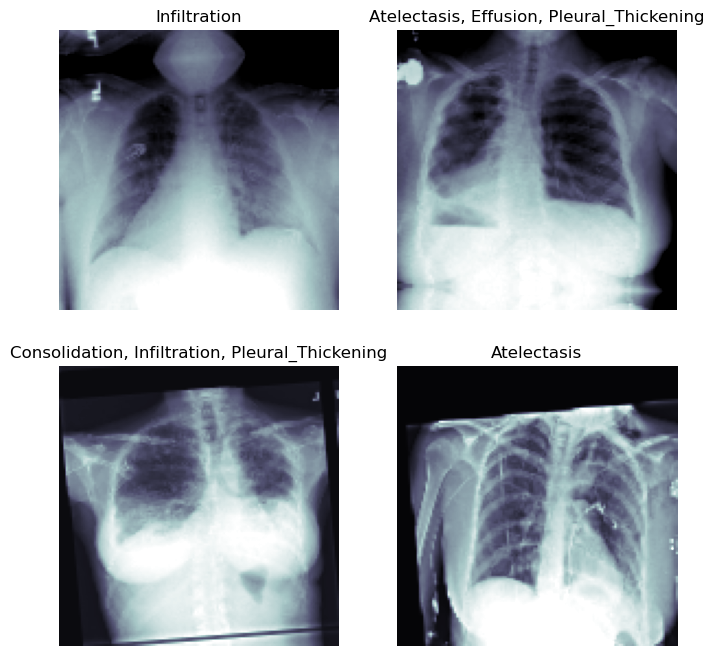

In [62]:
##

t_x, t_y = next(train_generator)

fig, m_axs = plt.subplots(2, 2, figsize = (8, 8))

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

### Activity

1. Build and train a CNN model from a scratch.  Apply different regularization techniques and data preprocessing to reduce overfitting.

In [63]:
##

model1 = Sequential([
    Conv2D(64, (2,2), activation='relu', input_shape=(128,128,1), padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout((0.6)),
    Dense(16, activation='relu'),
    Dropout((0.6)),
    Dense(len(all_labels), activation='sigmoid')
])

In [64]:
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │     8,388,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,389,709 (32.00 MB)

 Trainable params: 8,389,709 (32.00 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
##

model1.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['binary_accuracy'])

In [66]:
##

history1 = model1.fit(train_generator,
                      steps_per_epoch=100,
                      validation_data = (X_test, y_test), 
                      epochs = 1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - binary_accuracy: 0.8000 - loss: 0.9926 - val_binary_accuracy: 0.8879 - val_loss: 0.6453


In [67]:
##

score = model1.evaluate(X_test, y_test)

print('Test loss: {:.3f}'.format(score[0]))
print('Test accuracy: {:.3f}'.format(score[1]))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - binary_accuracy: 0.8877 - loss: 0.6453
Test loss: 0.645
Test accuracy: 0.888


In [69]:
##

history1_2 = model1.fit(train_generator,
                        steps_per_epoch=50,
                        validation_data = (X_test, y_test),
                        epochs = 5)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - binary_accuracy: 0.8648 - loss: 0.5958 - val_binary_accuracy: 0.8879 - val_loss: 0.5612
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - binary_accuracy: 0.8675 - loss: 0.5641 - val_binary_accuracy: 0.8879 - val_loss: 0.5252
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - binary_accuracy: 0.8697 - loss: 0.5346 - val_binary_accuracy: 0.8879 - val_loss: 0.4899
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - binary_accuracy: 0.8673 - loss: 0.5032 - val_binary_accuracy: 0.8879 - val_loss: 0.4583
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - binary_accuracy: 0.8703 - loss: 0.4766 - val_binary_accuracy: 0.8879 - val_loss: 0.4304


In [70]:
##

score1_2 = model1.evaluate(X_test, y_test)

print('Test loss: {:.3f}'.format(score1_2[0]))
print('Test accuracy: {:.3f}'.format(score1_2[1]))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - binary_accuracy: 0.8877 - loss: 0.4312
Test loss: 0.430
Test accuracy: 0.888


In [71]:
for c_label, s_count in zip(all_labels, 100*np.mean(y_test,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 17.38%
Cardiomegaly: 3.91%
Consolidation: 7.81%
Edema: 3.71%
Effusion: 22.46%
Emphysema: 4.49%
Fibrosis: 2.15%
Infiltration: 39.06%
Mass: 13.48%
Nodule: 13.48%
Pleural_Thickening: 4.69%
Pneumonia: 3.12%
Pneumothorax: 9.96%


In [72]:
pred_Y = model1.predict(X_test,
                        batch_size = 32,
                        verbose = True)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


2.  Plot the training and validation loss and accuracy. The target accuracy is 85 and above.

In [73]:
history1_2.history.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

In [74]:
## Function for plotting the loss functions, accuracy and ROC

def plot_loss_accuracy(history):
    
    fig = plt.figure(figsize=(30, 30))
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(history.history["loss"],'r-o', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-o', label="Validation Loss")
    ax.legend(prop={'size': 21})
    ax.set_title('BINARY ENTROPY LOSS')
    ax.grid(True)

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(history.history["binary_accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_binary_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend(prop={'size': 21})
    ax.set_title('ACCURACY')
    ax.grid(True)

In [75]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {}'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01], )

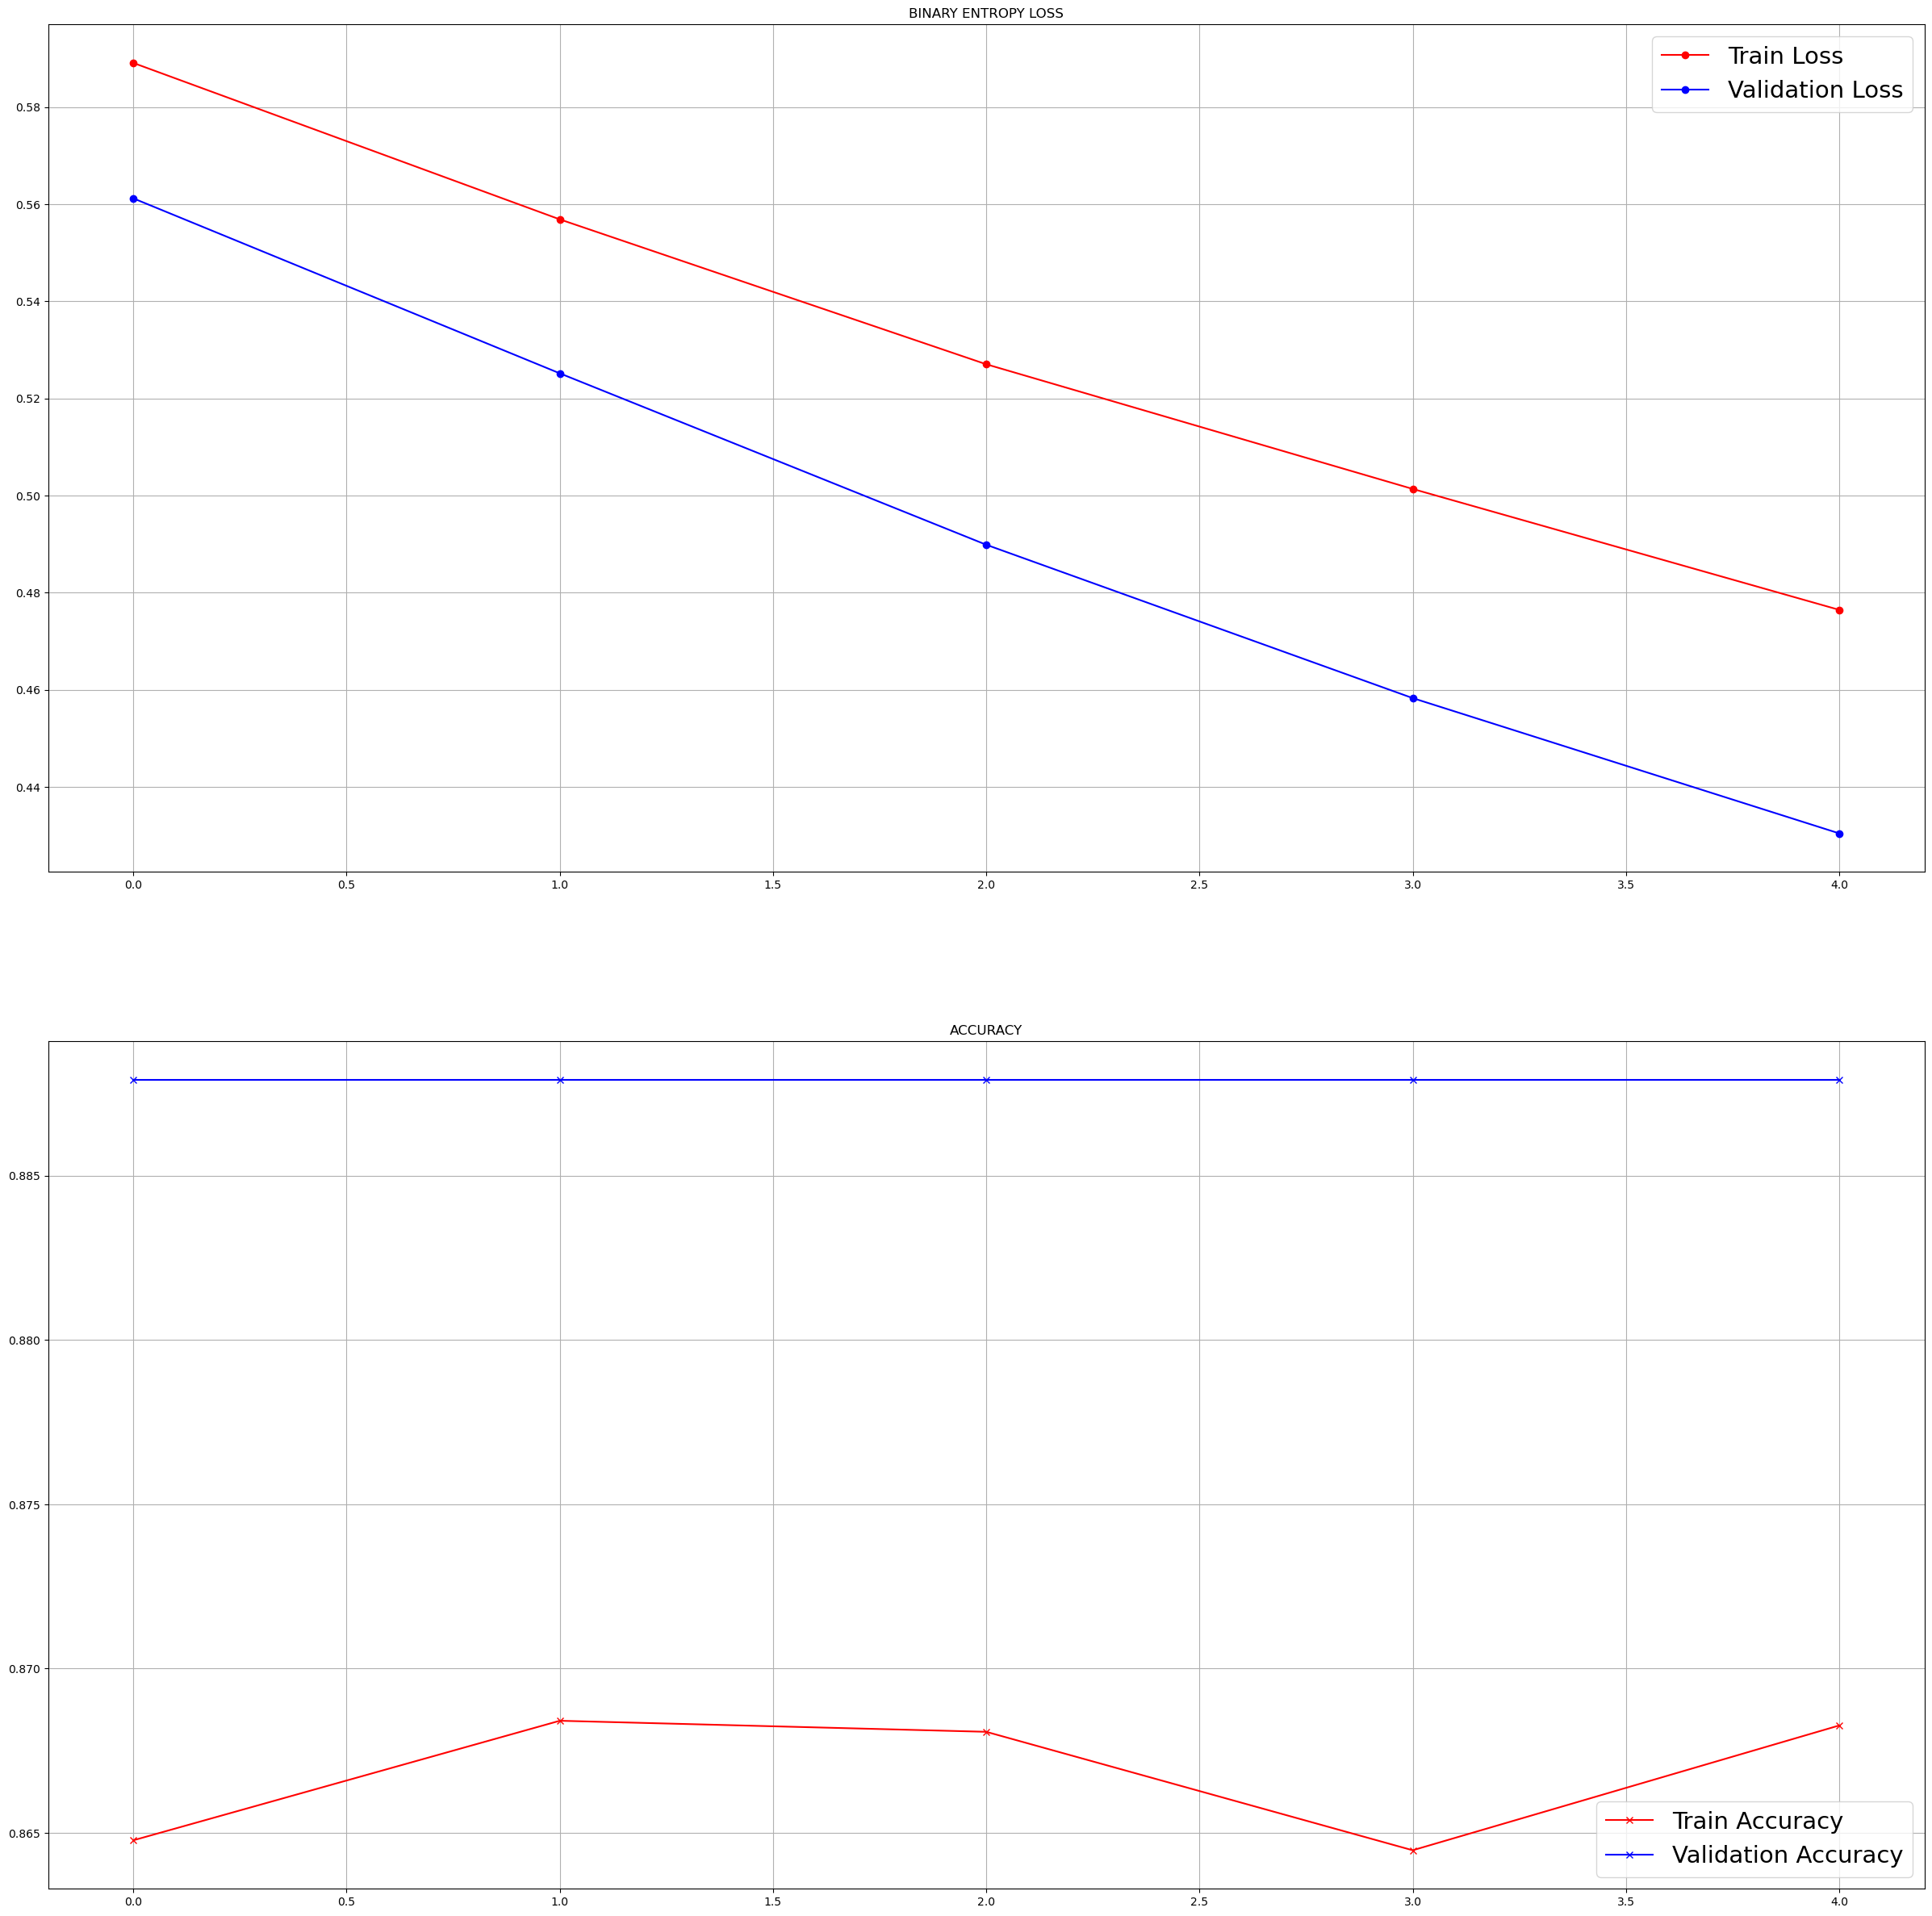

In [76]:
## Training and Validation Accuracy and Loss

plot_loss_accuracy(history1_2)

Text(0, 0.5, 'True Positive Rate')

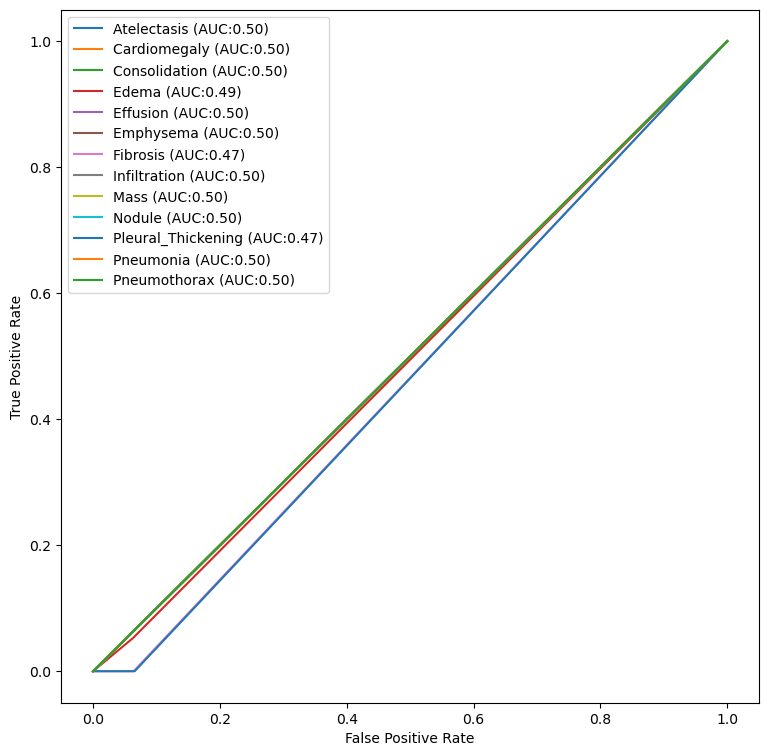

In [77]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

3.  Use the assigned pre-trained model and fine-tuned it.

In [160]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers
base_mobilenet_model = MobileNet(input_shape =(128,128,1), 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))

multi_disease_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ ?                      │     3,228,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,288 (12.31 MB)

 Trainable params: 3,206,400 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

4. Build and train a CNN model using the modified pretrained model.

In [161]:
model2.compile(optimizer="adam",
               loss="binary_crossentropy",
               metrics=["binary_accuracy"])

In [163]:
history2 = model2.fit(train_generator,
                        steps_per_epoch=50,
                        validation_data = (X_test, y_test),
                        epochs = 1)

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "block1_conv1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 128, 128, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 1), dtype=float32)
  • training=True
  • mask=None

In [ ]:
##

score2 = model2.evaluate(X_test, y_test)

print('Test loss: {:.3f}'.format(score2[0]))
print('Test accuracy: {:.3f}'.format(score2[1]))

In [ ]:
for c_label, s_count in zip(all_labels, 100*np.mean(y_test,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

In [ ]:
pred_Y = model2.predict(X_test,
                        batch_size = 32,
                        verbose = True)

5. Plot the training and validation loss and accuracy. The target accuracy is 95 and above.

In [ ]:
plot_loss_accuracy(history2)

In [ ]:
plot_roc(y_test, pred_Y, MODEL_2):

6. Use the classification report, confusion matrix and ROC over AUC metric to evaluate also the performance of the scratch and using pre-trained mode

In [ ]:
## ROC over AUC

#plot_roc(y_test, y_pred, model_name):

In [ ]:
## Classification Report



In [ ]:
## Confusion Matrix



## Conclusion